# Image Classifier
Classifying images using ResNet50 and softmax

In [1]:
from tensorflow.keras import backend as K
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

2023-07-28 13:38:02.035718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Split folders to train/test using [this](https://github.com/jfilter/split-folders) module

## Data Collection

In [2]:
# Define the classes
classes = ['bottle','cup','spectacles','shoes']

In [3]:
# define an image data generator
data_gen = ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=preprocess_input,
    # fill_mode='nearest',
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2
)

## Train-Test Split

In [4]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='../data/output/train',
        class_mode="categorical",
        classes=classes,
        batch_size=150,
        target_size=(224, 224),
)

Found 388 images belonging to 4 classes.


In [5]:
val_data_gen = data_gen.flow_from_directory(
        directory='../data/output/val/',
        class_mode="categorical",
        classes=classes,
        batch_size=150,
        target_size=(224, 224),
)

Found 20 images belonging to 4 classes.


In [6]:
train_data_gen.class_indices

{'bottle': 0, 'cup': 1, 'spectacles': 2, 'shoes': 3}

In [7]:
classes

['bottle', 'cup', 'spectacles', 'shoes']

## Model Creation

In [8]:
K.clear_session()

#1. Select the convolutional base / Pretrained network
base_model = ResNet50(include_top=False)     # will remove last 2 layers (pooling and prediction)

In [9]:
#2. Freeze the weights
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [10]:
# 3. Create your model with pretrained network as base model
inputs = Input(shape=(224,224,3))

base = base_model(inputs)

In [11]:
# dont forget to flatten out before the final layer
flatten = GlobalAveragePooling2D()(base)

outputs = Dense(4, activation='softmax')(flatten)   # 'bottle','cup','spectacles','shoes'

model_tf = Model(inputs,outputs)

### Compile and train

In [12]:
model_tf.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model_tf.fit(train_data_gen,
          verbose=2, # how the training log should get printed 
          epochs=15,
          validation_data=val_data_gen)

Epoch 1/15
3/3 - 45s - loss: 0.1124 - accuracy: 0.9794 - val_loss: 0.3058 - val_accuracy: 0.9000 - 45s/epoch - 15s/step
Epoch 2/15
3/3 - 45s - loss: 0.0988 - accuracy: 0.9820 - val_loss: 0.2302 - val_accuracy: 0.9000 - 45s/epoch - 15s/step
Epoch 3/15
3/3 - 47s - loss: 0.1005 - accuracy: 0.9871 - val_loss: 0.3131 - val_accuracy: 0.8500 - 47s/epoch - 16s/step
Epoch 4/15
3/3 - 47s - loss: 0.0830 - accuracy: 0.9897 - val_loss: 0.2548 - val_accuracy: 0.9000 - 47s/epoch - 16s/step
Epoch 5/15
3/3 - 46s - loss: 0.0736 - accuracy: 0.9923 - val_loss: 0.1849 - val_accuracy: 0.9500 - 46s/epoch - 15s/step
Epoch 6/15
3/3 - 46s - loss: 0.0660 - accuracy: 0.9923 - val_loss: 0.2158 - val_accuracy: 0.9500 - 46s/epoch - 15s/step
Epoch 7/15
3/3 - 46s - loss: 0.0537 - accuracy: 0.9923 - val_loss: 0.1894 - val_accuracy: 0.9500 - 46s/epoch - 15s/step
Epoch 8/15
3/3 - 46s - loss: 0.0717 - accuracy: 0.9845 - val_loss: 0.2113 - val_accuracy: 0.9000 - 46s/epoch - 15s/step
Epoch 9/15
3/3 - 45s - loss: 0.0541 - ac

Text(0.5, 0, 'epochs')

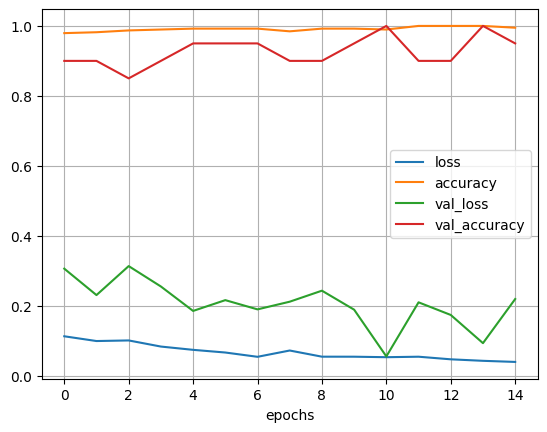

In [19]:
# Plot loss and accuracy curves
pd.DataFrame(data=history.history).plot()
plt.grid(True)
plt.xlabel('epochs')

## Predict

In [20]:
# path to test directory
base_path = "../data/output/test/"

# dict for folders and files
folders = {}

for folder in os.listdir(base_path):
    files = []
    for file in os.listdir(f'{base_path}{folder}/'):
        files.append(file)
    folders[folder] = files
folders

{'cup': ['09-09-15-982992.png',
  '09-26-41-050605.png',
  '09-26-30-391960.png',
  'cup2.png',
  '19-34-08-244641.png',
  '09-26-00-242062.png'],
 'spectacles': ['09-43-22-141626.png',
  '09-16-47-112236.png',
  '09-43-18-854922.png',
  '09-55-41-756194.png',
  '09-43-08-733138.png',
  '15-05-17-950216.png'],
 'shoes': ['19-37-49-904744.png',
  '15-14-14-950184.png',
  '15-14-11-487778.png',
  '15-14-12-117619.png',
  '09-21-16-675141.png',
  '15-14-04-679877.png'],
 'bottle': ['09-24-26-160041.png',
  '15-08-56-659408.png',
  'bottle8.png',
  '15-09-06-538840.png',
  '15-12-35-456966.png',
  '15-09-20-243612.png']}

In [21]:
def batch_prediction(folders = folders):
    num_images = 24
    plt.figure(figsize=(20, 20)) 
    idx = 1
    for folder in folders:
        files = folders.get(folder)
        
        for i in range(len(files)):
            
            """read and preprocess"""
            my_path = f"{base_path}{folder}/{files[i]}"
            pic = load_img(my_path,target_size=(224,224))
            numpy_image = np.array(pic)
            image_batch = np.expand_dims(numpy_image, axis=0)
            
            processed_image = preprocess_input(image_batch)
            
            """predict"""
            predictions = model_tf.predict(processed_image)
            print(predictions)

            # Get the index of the highest probability
            predicted_class_index = np.argmax(predictions)
            
            # Get the label corresponding to the highest probability
            predicted_label = classes[predicted_class_index]
        
    
            """plot"""
            plt.subplot(6,4, idx);
            plt.tight_layout()
            plt.imshow(pic)
            plt.title(f"{predicted_label}" )

            idx += 1
            
    plt.show()
    # return None

1/1 [==============================] - 0s 175ms/step
[[1.8047648e-03 9.9527633e-01 2.7111960e-03 2.0776401e-04]]
1/1 [==============================] - 0s 153ms/step
[[1.1556322e-03 9.9774098e-01 7.0888305e-04 3.9456110e-04]]


/var/folders/w7/bd51g8b90qvb5ykzr912g8jw0000gn/T/ipykernel_33671/530791221.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


1/1 [==============================] - 0s 173ms/step
[[0.02459169 0.9688033  0.00241001 0.00419495]]
1/1 [==============================] - 0s 172ms/step
[[2.4484904e-04 9.9556029e-01 2.3061412e-03 1.8887332e-03]]
1/1 [==============================] - 0s 150ms/step
[[0.00720783 0.57869893 0.02313181 0.39096144]]
1/1 [==============================] - 0s 151ms/step
[[1.4038011e-03 9.9819487e-01 1.9262482e-04 2.0866995e-04]]
1/1 [==============================] - 0s 144ms/step
[[1.0715632e-03 9.4476191e-04 9.9795842e-01 2.5263953e-05]]
1/1 [==============================] - 0s 150ms/step
[[5.69782933e-05 1.16866046e-04 9.99794304e-01 3.18114580e-05]]
1/1 [==============================] - 0s 151ms/step
[[1.6758427e-01 3.0373459e-04 8.1737530e-01 1.4736690e-02]]
1/1 [==============================] - 0s 159ms/step
[[5.31110505e-04 1.20022334e-04 9.98969913e-01 3.78978380e-04]]
1/1 [==============================] - 0s 155ms/step
[[0.03727986 0.0264705  0.93308276 0.00316689]]
1/1 [======

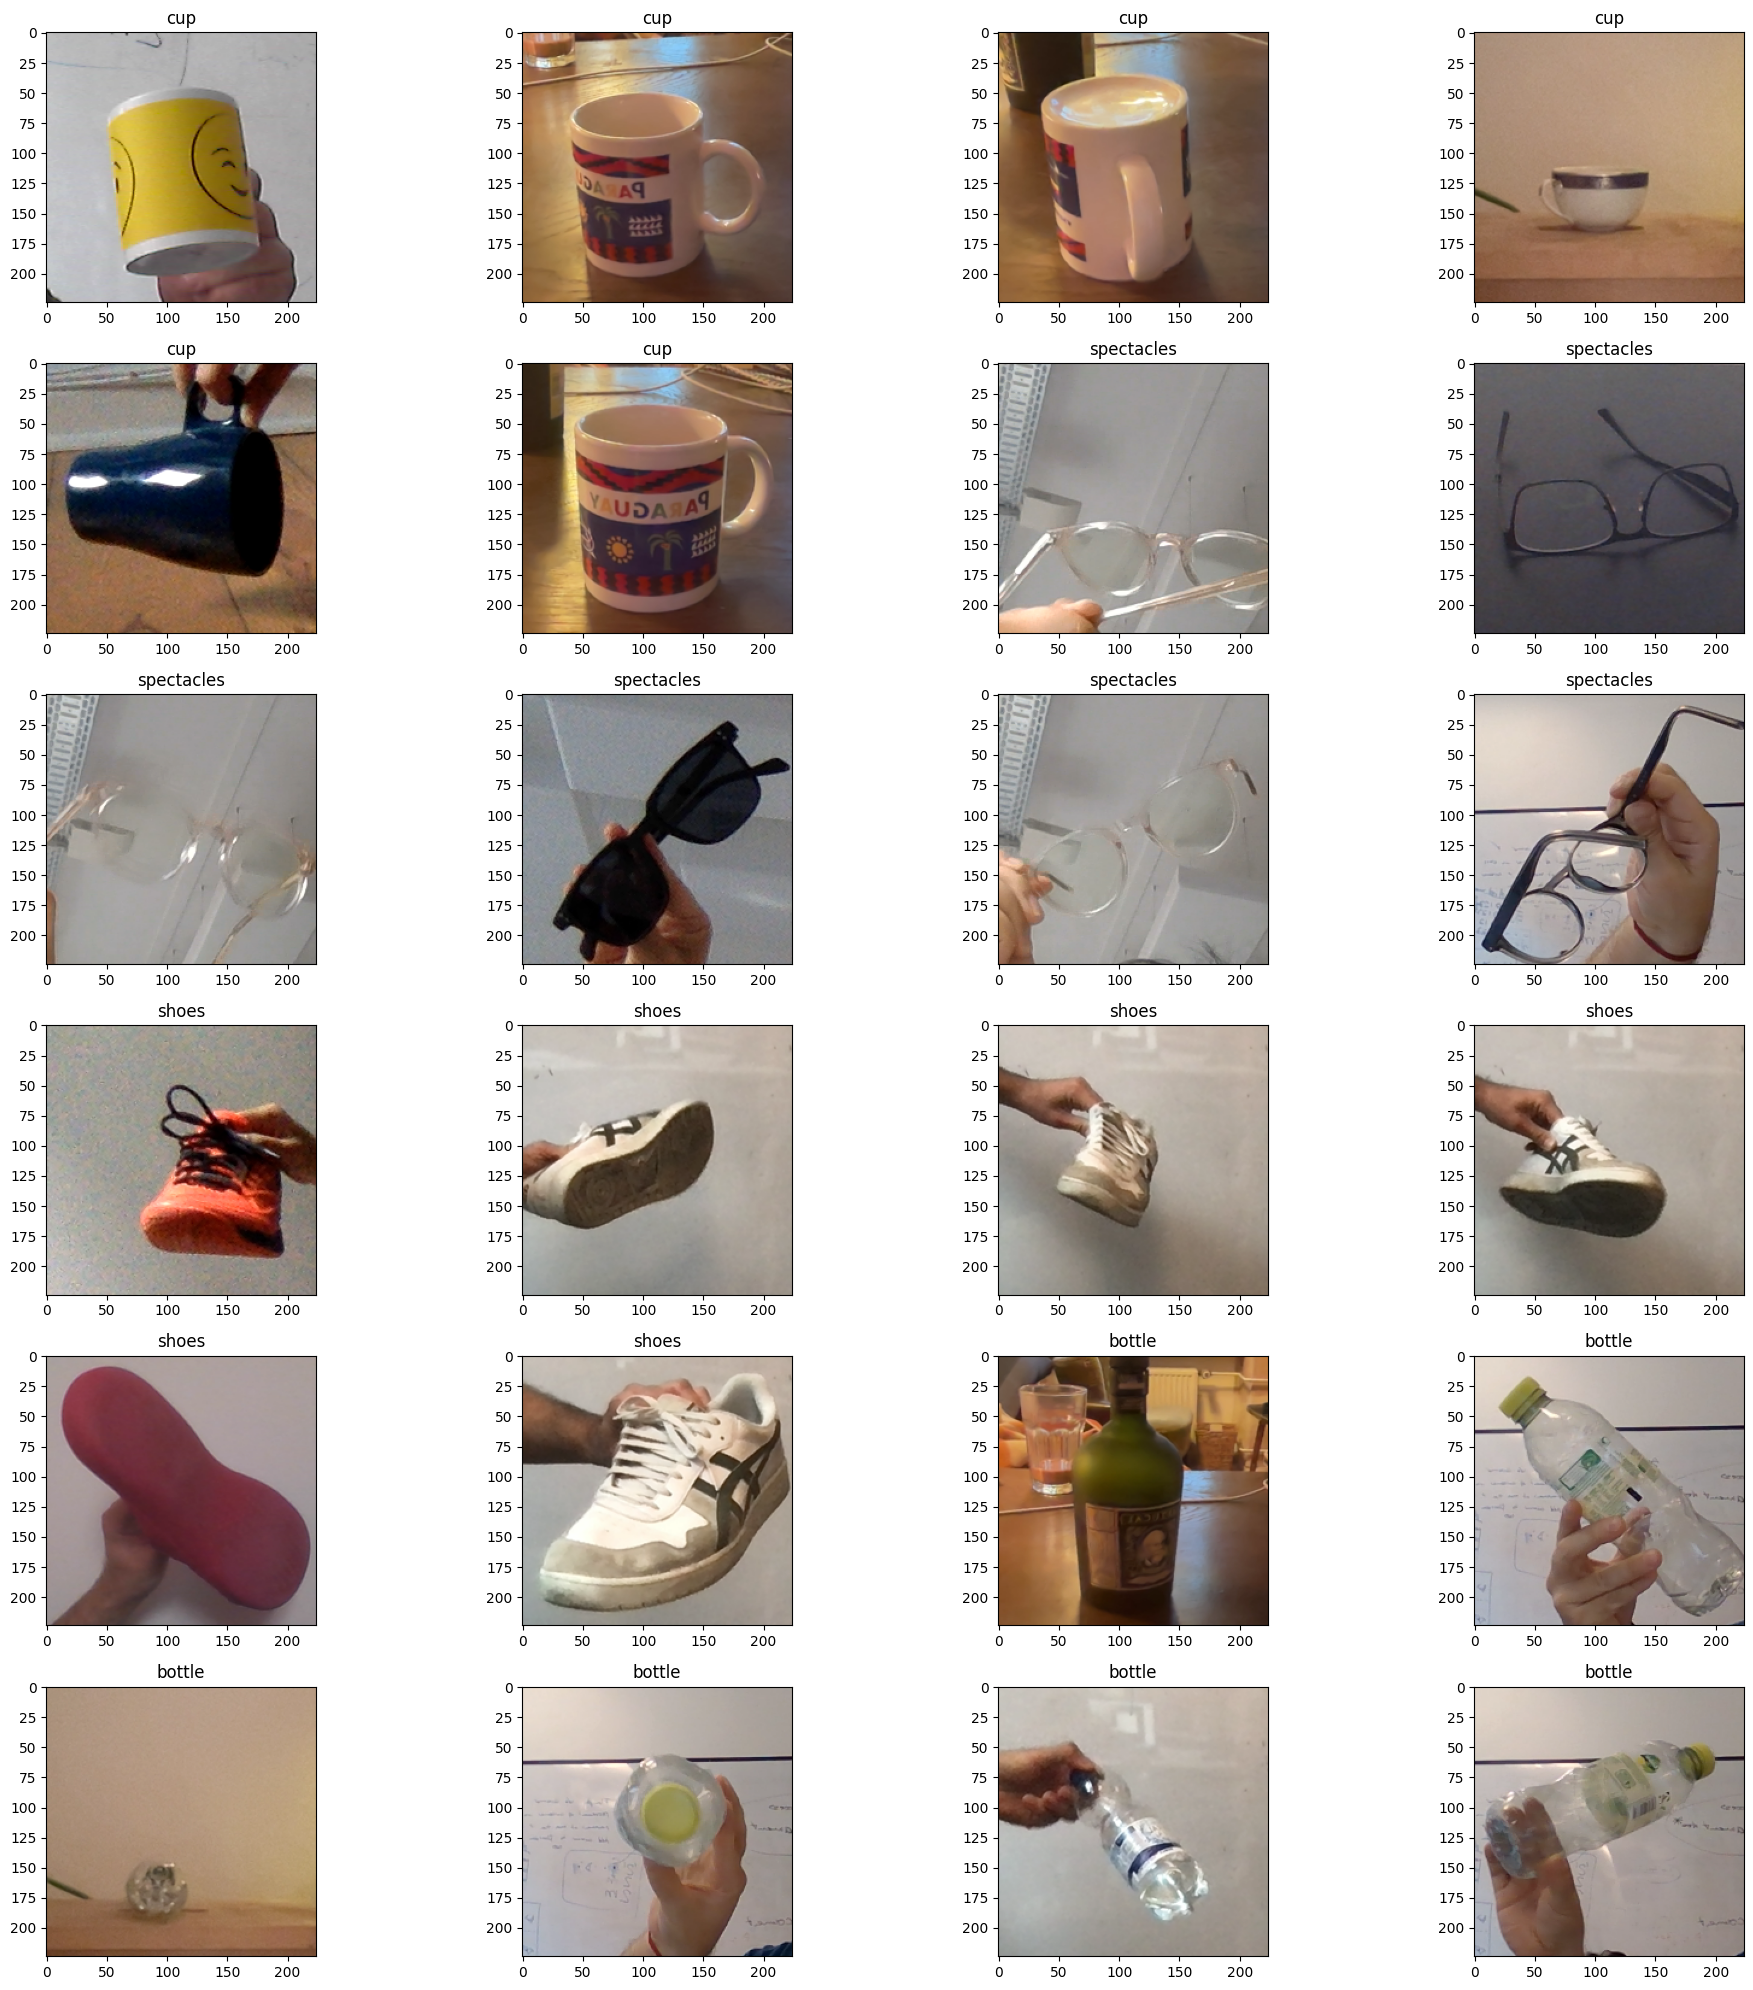

In [22]:
batch_prediction()

## Save Model

In [23]:
model_tf.save('image_classifier.h5')

/Users/nadine/anaconda3/envs/deep_learning/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
